In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

tf.enable_eager_execution()
tf.set_random_seed(230)
print(tf.__version__)

from matplotlib import pyplot as plt

import sys
sys.path.append('..')

/Documents/venv3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.11.0


In [2]:
from configs.seq_fd_gru import hparams
hparams = hparams()
print(hparams)

[('batch_size', 800), ('datagen', 'prodn'), ('in_seq_len', 168), ('input_channels', 1), ('input_dim', 5), ('lambd', 1e-06), ('learning_rate', 0.001), ('logs_path', '/tmp/tensorflow_logs'), ('lr_decay', 0.99), ('neurons_unit', 32), ('norm_epsilon', 1e-12), ('num_layers', 1), ('out_seq_len', 24), ('output_channels', 1), ('output_dim', 1), ('test_split', 0.1), ('train_split', 0.8), ('val_split', 0.1)]


In [179]:
hparams=tf.contrib.training.HParams(
        batch_size=800,
        in_seq_len=168,
        input_dim=5,
        input_channels=1,
        out_seq_len=24,
        output_dim=1,
        output_channels=1,
        num_layers=1,
        neurons_unit=32,
        learning_rate = 10 ** -2.5,
        lr_decay = 0.99,
        lambd = 1e-6,
        train_split = 0.8,
        val_split = 0.1,
        test_split = 0.1,
        norm_epsilon = 1e-12,
        datagen = 'prodn',
        logs_path = '/tmp/tensorflow_logs')

In [177]:
from data_loader.biogas import *
get_fields = 'AT305'
dataset, dataset_val, dataset_test = load_data(hparams, mode=get_fields, normalise='local_max_min')
inp, target, mask, x_max = next(iter(dataset))

In [13]:
tf.keras.layers.Conv1D(1, 2, padding='valid', activation='linear', use_bias=False,
                                         kernel_initializer = tf.constant_initializer([-1,1]))

[]

In [18]:
class pAttention(tf.keras.Model):
    def __init__(self):
        super(pAttention, self).__init__()
        self.W1 = tf.Variable(2., name='W_separation')
        self.W2 = tf.Variable(1., name='W_scale')

    def cov(self, x):

        n_dim  = tf.cast(tf.shape(x)[1], tf.float32) - 1
        mu_x   = x - tf.reduce_mean(x, axis=1, keep_dims=True)
        cov_xx = tf.matmul(mu_x, mu_x, transpose_a=True) / n_dim
        
        return cov_xx
    
    def call(self, x, hidden):
        cov = self.cov(x)
        cov = tf.reduce_sum(cov, axis=1)
        cov = cov / tf.reduce_max(cov, axis=1, keep_dims=True)

        score   = tf.exp(self.W1) * cov
        weights = tf.nn.softmax(score, axis=1)
        weights = tf.expand_dims(weights, axis=1)
        
        outputs = self.W2 * tf.reduce_mean(weights * tf.squeeze(hidden), axis=-1, keepdims=True) 
        
        return outputs

In [154]:
class MicroConvRNN(tf.keras.Model):
    def __init__(self, input_dim, output_dim, in_seq_len, out_seq_len, neurons_unit, batch_size, name=None):
        super(MiniConvRNN, self).__init__()

        self.input_dim    = input_dim
        self.output_dim   = output_dim
        self.in_seq_len   = in_seq_len
        self.out_seq_len  = out_seq_len
        self.neurons_unit = neurons_unit
        self.batch_size   = batch_size
        
        self.cat = tf.keras.layers.Concatenate(axis=-1)
        
        self.conv1_2x1  = tf.keras.layers.Conv1D(1, 2, padding='valid', activation='linear', use_bias=False,
                                                 kernel_initializer = tf.constant_initializer([-1,1]),
                                                 name='conv1_first_diff_2')
        self.attn = pAttention()
        
    def reshape_deep(self, x):
        x = tf.reshape(x, [self.batch_size, self.input_dim, self.out_seq_len, -1])
        return tf.transpose(x, [0,2,1,3])
        
    def reshape_wide(self, x):
        x = tf.transpose(x, [0,2,1,3])
        return tf.reshape(x, [self.batch_size, self.input_dim * self.out_seq_len, -1])
    
    def encode(self, x):
        pos = self.out_seq_len * self.input_dim
        
        conv1 = self.conv1_2x1(x)

        return self.reshape_deep(conv1[:,-pos:])
        
    def call(self, inp, mask):
        
        enc_out = self.encode(inp)
        
        pos = self.out_seq_len * self.input_dim
        context = self.reshape_deep(inp[:,-pos:])
        context = self.attn(tf.squeeze(context), enc_out)
        context = tf.cumsum(context, axis=1)
        
        x = inp[:,-1:]

        return (x + context) * mask

In [154]:
class MiniConvRNN(tf.keras.Model):
    def __init__(self, input_dim, output_dim, in_seq_len, out_seq_len, neurons_unit, batch_size, name=None):
        super(MiniConvRNN, self).__init__()

        self.input_dim    = input_dim
        self.output_dim   = output_dim
        self.in_seq_len   = in_seq_len
        self.out_seq_len  = out_seq_len
        self.neurons_unit = neurons_unit
        self.batch_size   = batch_size
        
        self.cat = tf.keras.layers.Concatenate(axis=-1)
        
        self.conv1_2x1  = tf.keras.layers.Conv1D(1, 2, padding='valid', activation='linear', use_bias=False,
                                                 kernel_initializer = tf.constant_initializer([-1,1]),
                                                 name='conv1_first_diff_2')
        self.conv1_3x1  = tf.keras.layers.Conv1D(15, 2, padding='valid', activation='relu', use_bias=False,
                                                 name='conv1_2x1_relu')

        #self.conv1_3x1  = tf.keras.layers.Conv1D(1, 3, padding='valid', activation='linear', use_bias=False,
        #                                         kernel_initializer = tf.constant_initializer([-1,0,1]),
        #                                         name='conv1_first_diff_3')


        self.conv1_f    = tf.keras.layers.Conv2D(1, (1,16), padding='valid', activation='linear', use_bias=False,
                  kernel_initializer = tf.constant_initializer(np.array([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])))
        
        #self.conv1_3x1  = tf.keras.layers.Conv1D(1, 24, padding='valid', activation='linear', use_bias=False,
        #            kernel_initializer = tf.constant_initializer(np.zeros(24)),
        #            name='conv1_first_diff_24')
        #self.conv2_2x1  = tf.keras.layers.Conv1D(2, 2, padding='valid', activation='tanh')
        #self.conv2_36x1 = tf.keras.layers.Conv2D(1, (1,2), padding='valid', activation='tanh')

        self.attn = pAttention()
        
    def reshape_deep(self, x):
        x = tf.reshape(x, [self.batch_size, self.input_dim, self.out_seq_len, -1])
        return tf.transpose(x, [0,2,1,3])
        
    def reshape_wide(self, x):
        x = tf.transpose(x, [0,2,1,3])
        return tf.reshape(x, [self.batch_size, self.input_dim * self.out_seq_len, -1])
    
    def encode(self, x):
        pos = self.out_seq_len * self.input_dim
        
        conv1_2x1 = self.conv1_2x1(x)
        conv1_3x1 = self.conv1_3x1(x)
        
        conv1 = self.cat([conv1_2x1[:,-pos:], conv1_3x1[:,-pos:]])
        conv1 = self.conv1_f(tf.expand_dims(conv1,-1))
        conv1 = tf.squeeze(conv1)

        return self.reshape_deep(conv1)
        
    def call(self, inp, mask):
        
        enc_out = self.encode(inp)
        
        pos = self.out_seq_len * self.input_dim
        context = self.reshape_deep(inp[:,-pos:])
        context = self.attn(tf.squeeze(context), enc_out)
        context = tf.cumsum(context, axis=1)
        
        x = inp[:,-1:]

        return (x + context) * mask
        """output = x + tf.squeeze(tf.reduce_sum(enc_out,2))
        
        return tf.expand_dims(output, -1)
        
        pos = self.out_seq_len * self.input_dim
        context = self.reshape_deep(inp[:,-pos:])
        context = self.attn(tf.squeeze(context), enc_out)
        
        
        outputs = context + x
        
        return tf.expand_dims(outputs,-1)"""

In [180]:
inp, target, mask, x_max = next(iter(dataset))
model = MiniConvRNN(hparams.input_dim, hparams.output_dim, hparams.in_seq_len, hparams.out_seq_len,
               hparams.neurons_unit, hparams.batch_size)
conv1 = model.encode(inp)
#model.conv1_2x1.set_weights([np.array([[[-1.0]], [[ 1.0]]], dtype=np.float32),
#                             np.array([0.], dtype=np.float32)])
model.conv1_2x1.set_weights([np.array([[[-1.0]], [[ 1.0]]], dtype=np.float32)])
fcast = model.call(inp, mask)
conv1 = model.encode(inp)
cox = tf.cumsum(tf.squeeze(conv1))
fcast.shape, conv1.shape, cox.shape

(TensorShape([Dimension(800), Dimension(24), Dimension(1)]),
 TensorShape([Dimension(800), Dimension(24), Dimension(5), Dimension(1)]),
 TensorShape([Dimension(800), Dimension(24), Dimension(5)]))

In [181]:
atn  = pAttention().cov(tf.squeeze(model.reshape_deep(inp[:,-pos:])))
#atn_ = tf.reduce_sum(atn, axis=1)
atn_ = np.sum((atn / np.max(atn, axis=(1,2), keepdims=True)), axis=1)
act  = tf.nn.softmax(np.exp(0.5) * atn_, axis=1)
atn[160], atn_[160], act[160] * 100

(<tf.Tensor: id=22518445, shape=(5, 5), dtype=float32, numpy=
 array([[ 4.6574078e-06,  4.5633647e-06,  4.4817343e-06,  5.1870998e-06,
         -3.8845701e-05],
        [ 4.5633647e-06,  4.6095820e-06,  4.6124405e-06,  5.1791621e-06,
         -4.3028147e-05],
        [ 4.4817343e-06,  4.6124405e-06,  4.7906301e-06,  5.0374106e-06,
         -4.0990159e-05],
        [ 5.1870998e-06,  5.1791621e-06,  5.0374106e-06,  6.3716639e-06,
         -5.9521677e-05],
        [-3.8845701e-05, -4.3028147e-05, -4.0990159e-05, -5.9521677e-05,
          1.4008660e-03]], dtype=float32)>,
 array([-0.01424554, -0.01717766, -0.01575307, -0.026945  ,  0.86980504],
       dtype=float32),
 <tf.Tensor: id=22518450, shape=(5,), dtype=float32, numpy=
 array([12.095685 , 12.037353 , 12.0656595, 11.84506  , 51.956238 ],
       dtype=float32)>)

[<tf.Variable 'conv1_first_diff_2/kernel:0' shape=(2, 1, 1) dtype=float32, numpy=
array([[[-1.]],

       [[ 1.]]], dtype=float32)>]


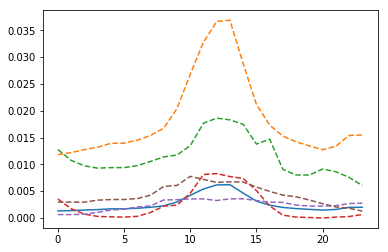

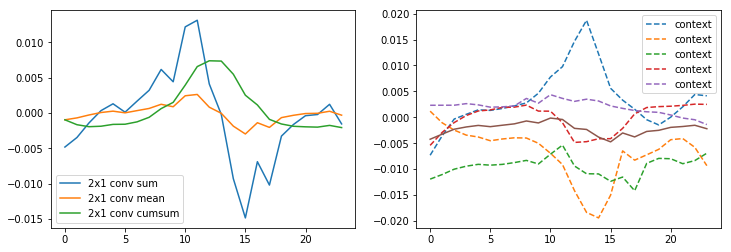

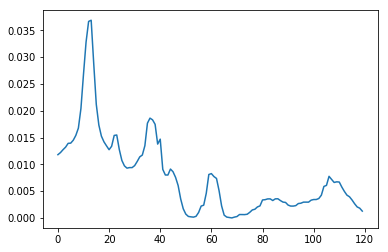

In [182]:
n = 24
pos = hparams.out_seq_len * hparams.input_dim
print(model.conv1_2x1.variables)

plt.plot(np.array(fcast[n]))
plt.plot(np.array(model.reshape_deep(inp[:,-pos:]))[n,:,:,0], '--')
plt.show()

plt.figure(figsize=(12,4))
ax = plt.subplot(1,2,1)
ax.plot(np.array(conv1[n]).sum(axis=(1)), label='2x1 conv sum')
ax.plot(np.array(conv1[n]).mean(axis=(1)), label='2x1 conv mean')
ax.plot(np.cumsum(conv1[n], axis=0).mean(axis=(1)), label='2x1 conv cumsum')
plt.legend()
ax = plt.subplot(1,2,2)
ax.plot(np.array(cox[n]), '--', label='context')
ax.plot(np.array(cox[n]).mean(axis=1))
plt.legend()
plt.show()

plt.plot(np.array(inp[n,-120:]))
plt.show()

## Train Model
loss_function: Build out MSE loss function with parameter regularisation

train_model: Runs the minibatch training loop

Epoch 1 Loss 0.0016 Accuracy 0.0016
Time taken for 1 epoch 1.0755 sec

Epoch 2 Loss 0.0008 Accuracy 0.0007
Time taken for 1 epoch 1.0150 sec

Epoch 3 Loss 0.0004 Accuracy 0.0003
Time taken for 1 epoch 0.9809 sec

Epoch 4 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 1.0649 sec

Epoch 5 Loss 0.0003 Accuracy 0.0002
Time taken for 1 epoch 1.0267 sec

Epoch 6 Loss 0.0002 Accuracy 0.0002
Time taken for 1 epoch 1.0375 sec

Epoch 7 Loss 0.0002 Accuracy 0.0002
Time taken for 1 epoch 1.0110 sec

Epoch 8 Loss 0.0002 Accuracy 0.0002
Time taken for 1 epoch 1.0076 sec

Epoch 9 Loss 0.0002 Accuracy 0.0002
Time taken for 1 epoch 1.0104 sec

Epoch 10 Loss 0.0002 Accuracy 0.0002
Time taken for 1 epoch 1.0172 sec

Epoch 11 Loss 0.0002 Accuracy 0.0002
Time taken for 1 epoch 1.0031 sec

Epoch 12 Loss 0.0002 Accuracy 0.0002
Time taken for 1 epoch 0.9984 sec

Epoch 13 Loss 0.0002 Accuracy 0.0002
Time taken for 1 epoch 1.0061 sec

Epoch 14 Loss 0.0002 Accuracy 0.0002
Time taken for 1 epoch 1.0119 sec

E

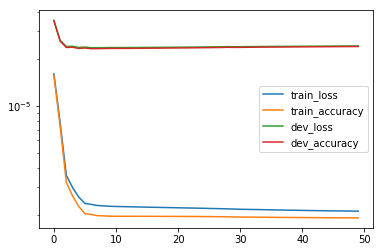

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
concatenate_25 (Concatenate) multiple                  0         
_________________________________________________________________
conv1_first_diff_2 (Conv1D)  multiple                  2         
_________________________________________________________________
conv1_2x1_relu (Conv1D)      multiple                  30        
_________________________________________________________________
conv2d_25 (Conv2D)           multiple                  16        
_________________________________________________________________
p_attention_34 (pAttention)  multiple                  2         
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________


In [158]:
import trainers.tf_eager_trainer as trainer

# Run a training batch
tf.set_random_seed(231) # Set seed

# Initialise model and optimiser
model = MiniConvRNN(hparams.input_dim, hparams.output_dim, hparams.in_seq_len, hparams.out_seq_len,
                hparams.neurons_unit, hparams.batch_size)
optimizer = tf.train.AdamOptimizer(learning_rate = hparams.learning_rate)

# Start training run
loss, accuracy, run_time, stats = trainer.train_model(model, optimizer, dataset, hparams,
                                                      epochs=50, verbose=True, dev_dataset=dataset_val)

# Display results
print('Loss {:.4f} Accuracy {:.4f} Time {:.4f}'.format(loss * 10000, accuracy * 10000, run_time))

plt.figure()
for name, stat in stats.items():
    if name != 'time':
        plt.plot(stat, label=name)
plt.legend()
plt.yscale('log')
plt.show()

#trainer.save_model(model, optimizer, dataset_val, hparams, 'fd_mini' + get_fields.replace(' ', '_'), stats=stats)
model.summary()

In [159]:
model.variables, optimizer._lr

([<tf.Variable 'mini_conv_rnn_25/conv1_first_diff_2/kernel:0' shape=(2, 1, 1) dtype=float32, numpy=
  array([[[-0.99977124]],
  
         [[ 0.99983126]]], dtype=float32)>,
  <tf.Variable 'mini_conv_rnn_25/conv1_2x1_relu/kernel:0' shape=(2, 1, 15) dtype=float32, numpy=
  array([[[ 2.33177364e-01,  3.64535451e-02,  3.15728523e-02,
           -1.06431721e-02, -3.65101296e-05,  4.48249368e-04,
           -1.44662866e-02,  3.10746253e-01, -7.50979176e-03,
           -5.18982160e-05,  1.91931590e-01,  1.69619042e-02,
           -1.83463953e-02,  3.36226553e-01, -5.12792841e-02]],
  
         [[ 8.87711998e-03, -8.49645305e-03, -7.13113230e-03,
           -1.08407885e-02,  2.06134502e-12, -4.87320387e-04,
            7.33617553e-03,  1.38938576e-01, -6.83659734e-03,
           -6.77157844e-11,  1.69231176e-01, -4.90687564e-02,
           -1.71802379e-02,  2.21107036e-01,  1.86107576e-01]]],
        dtype=float32)>,
  <tf.Variable 'mini_conv_rnn_25/conv2d_25/kernel:0' shape=(1, 16, 1, 1) dtyp

In [184]:
loss, accuracy, run_time, stats = trainer.train_model(model, optimizer, dataset, hparams,
                                                      epochs=20, verbose=True, dev_dataset=dataset_val)
print(np.array(loss) * 10000, np.array(accuracy) * 10000, run_time)
model.variables, optimizer._lr

Epoch 1 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 1.1674 sec

Epoch 2 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 1.0483 sec

Epoch 3 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 1.0089 sec

Epoch 4 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.9846 sec

Epoch 5 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.9988 sec

Epoch 6 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.9946 sec

Epoch 7 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.9558 sec

Epoch 8 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.9860 sec

Epoch 9 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 1.0165 sec

Epoch 10 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.9965 sec

Epoch 11 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.9971 sec

Epoch 12 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.9948 sec

Epoch 13 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.9834 sec

Epoch 14 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.9827 sec

E

([<tf.Variable 'conv1_first_diff_2/kernel:0' shape=(2, 1, 1) dtype=float32, numpy=
  array([[[-0.9759248 ]],
  
         [[ 0.98294884]]], dtype=float32)>,
  <tf.Variable 'conv1_2x1_relu/kernel:0' shape=(2, 1, 15) dtype=float32, numpy=
  array([[[-9.8298773e-02,  3.2763362e-02,  9.3114935e-03, -3.5370711e-02,
           -3.3207382e-03,  9.1650216e-03, -9.7764786e-03, -2.9251877e-02,
           -8.2962135e-05, -2.3387652e-02, -8.0054952e-04, -6.6504716e-03,
           -1.7513521e-03, -1.5246527e-03, -4.4401330e-03]],
  
         [[ 3.7256699e-02, -4.5651998e-02,  3.0998960e-02,  2.6153227e-02,
           -2.8216995e-03, -1.4756589e-02, -1.6387760e-03, -1.4391461e-02,
           -1.1266267e-05, -2.4309276e-02,  4.8494051e-04, -6.3897762e-04,
            1.8009401e-03, -5.6818553e-04, -3.7305634e-03]]], dtype=float32)>,
  <tf.Variable 'conv2d_26/kernel:0' shape=(1, 16, 1, 1) dtype=float32, numpy=
  array([[[[ 7.43497550e-01]],
  
          [[ 2.02610474e-02]],
  
          [[ 9.16428491e-

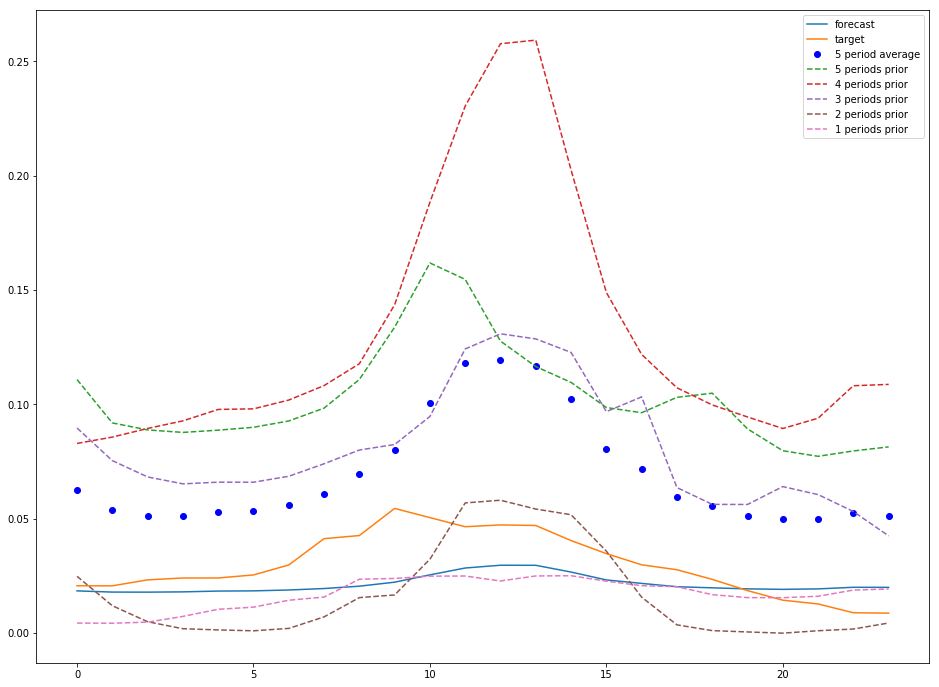

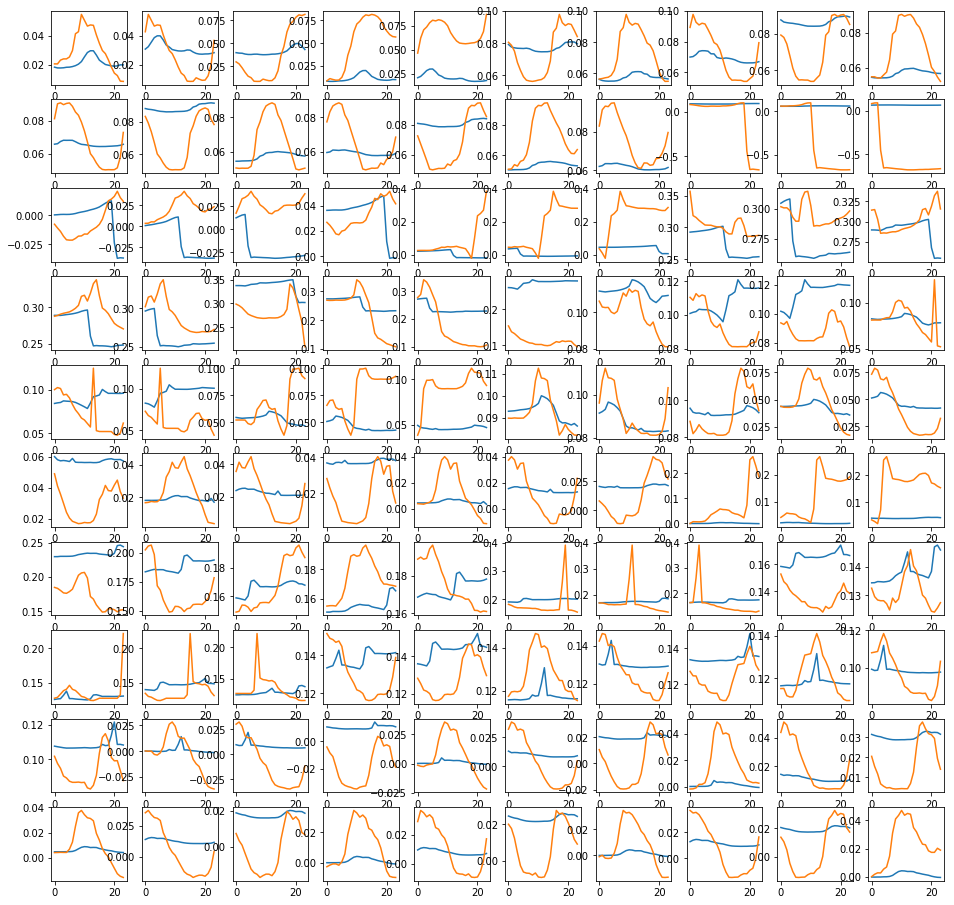

In [185]:
# show all sequences
# Select target sequence to show
TARGET_INDEX = 0

# Create forecast and rescale data
_, (inp, target, mask, x_max) = enumerate(dataset).__next__()
x_max = tf.expand_dims(x_max,-1)
forecast = model(inp, mask)
forecast *= x_max
target   *= x_max
inp      *= x_max
inp = tf.reshape(inp[:,-120:], [hparams.batch_size, hparams.input_dim, hparams.out_seq_len, -1])
inp = tf.transpose(inp, [0,2,1,3])

# Plot target sequence
plt.figure(figsize=(16,12))
plt.plot(np.squeeze(forecast[TARGET_INDEX,:,0]), label='forecast')
plt.plot(np.squeeze(target[TARGET_INDEX,:,0]), label='target')
plt.plot(np.mean(inp, axis=2)[TARGET_INDEX,:,0], 'bo', label='5 period average')
for i in range(hparams.input_dim):
    plt.plot(np.array(inp)[TARGET_INDEX,:,i,0], '--', label='%i periods prior' % (5-i))
plt.legend()
plt.show()

plt.figure(figsize=(16,16))
for i in range(0,800,8):
    ax = plt.subplot(10,10,i/8+1)
    ax.plot(np.squeeze(forecast[i]), label='forecast')
    ax.plot(np.squeeze(target[i]), label='target')
plt.show()

## Test Hyperparameters

In [152]:
np.random.seed(231)
models, stats = [], []

lr    = np.log10(hparams.learning_rate)
nodes = hparams.neurons_unit

inp, target, mask, x_max = next(iter(dataset))

#for lr in np.random.uniform(-8, -1, 10):
#for nodes in np.floor(2 ** np.arange(3,9)):
for lr in range(-8, 0, 1):
    lr /= 2

    # Run a training batch
    tf.set_random_seed(231) # Set seed

    # Initialise model and optimiser
    model = MiniConvRNN(hparams.input_dim, hparams.output_dim, hparams.in_seq_len, hparams.out_seq_len,
                       hparams.neurons_unit, hparams.batch_size)
    conv1 = model.encode(inp)
    model.conv1_2x1.set_weights([np.array([[[-1.0]], [[ 1.0]]], dtype=np.float32),
                             np.array([0.], dtype=np.float32)])
    optimizer = tf.train.AdamOptimizer(learning_rate = 10 ** lr)

    # Start training run
    loss, accuracy, run_time, stat = \
        trainer.train_model(model, optimizer, dataset, hparams, epochs = 50, verbose=False)
    print('Learning Rate {:.4f} Loss {:.4f} Accuracy {:.4f} Time {:.1f}'.format(lr, loss*10000, accuracy * 10000, run_time))
    
    models.append(model)
    stats.append(stat)

Learning Rate -4.0000 Loss 0.0269 Accuracy 0.0269 Time 12.4
Learning Rate -3.5000 Loss 0.0268 Accuracy 0.0268 Time 12.3
Learning Rate -3.0000 Loss 0.0263 Accuracy 0.0263 Time 12.5
Learning Rate -2.5000 Loss 0.0264 Accuracy 0.0264 Time 13.4
Learning Rate -2.0000 Loss 0.0263 Accuracy 0.0263 Time 13.1
Learning Rate -1.5000 Loss 0.0253 Accuracy 0.0253 Time 13.0
Learning Rate -1.0000 Loss 0.0224 Accuracy 0.0224 Time 12.5
Learning Rate -0.5000 Loss 0.0196 Accuracy 0.0196 Time 14.4


## Test Model Accuracy

In [163]:
model_accuracy = []

Total Accuracy: 0.0337


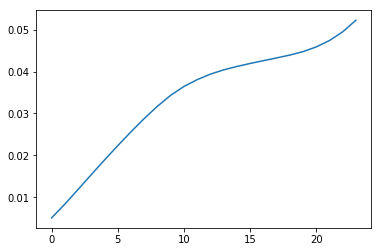

In [195]:
START_POINT = 0
total_accuracy = []
x_variance = x_var(hparams, mode=get_fields, normalise='local_max_min')

for i, (inp, target, mask, x_max) in enumerate(dataset):
    forecast = model(inp, mask)

    accuracy = tf.squeeze(forecast - target) * x_max
    accuracy = accuracy ** 2 / x_variance
    accuracy = np.mean(accuracy, axis=0)
    
    total_accuracy.append(accuracy)

model_accuracy.append((hparams.in_seq_len, np.mean(total_accuracy, axis=0)))
    
print('Total Accuracy: %.4f' % np.mean(total_accuracy))
plt.plot(np.mean(total_accuracy, axis=0))
plt.show()

In [191]:
preds = np.array(forecast[:,:,0])*np.array(x_max)
acts  = np.array(target[:,:,0])*np.array(x_max)
errors = np.abs(preds - acts)

mses = np.mean(errors**2, axis = 0)
maes = np.mean(errors, axis = 0)
mapes = np.mean(errors/acts, axis = 0)
rses = np.mean(errors**2, axis = 0)/np.var(acts, axis = 0)

In [192]:
rses

array([0.18735868, 0.30754936, 0.4377181 , 0.55556816, 0.6665768 ,
       0.77733946, 0.8847315 , 0.98752964, 1.0706679 , 1.1227998 ,
       1.1361223 , 1.1140729 , 1.0560311 , 0.97406596, 0.88355416,
       0.7935424 , 0.7069946 , 0.6187916 , 0.5235583 , 0.43178767,
       0.3551168 , 0.30700448, 0.3030604 , 0.34593818], dtype=float32)